In [1]:
import sys
sys.path.append('/Users/chadestep/GitHub/surmeierlab/neurphys/')

In [2]:
# because we made it, and it's awesome
import neurphys as nu

# because we always use them
import os
import time
import itertools
from glob import glob
import numpy as np
import pandas as pd
import scipy.stats
import statsmodels.sandbox.stats.multicomp
import matplotlib.pyplot as plt
from tqdm import *

%matplotlib inline
plt.style.use('estep_style')

# Analyzing the action potential after hyperpolarization (AHP)

It may look a little convoluted as to why I did the analysis this way, with a whole bunch of nested dictionaries full of more data structures. And yes, to some extent it is, but this is analysis isn't mission critical by any means so I just cleaned it up to make a little easier to debug if I needed to come through and modify something. 

In reality, I need all the data structures in case I need to go back and reanalyze or visualize any of them at a moments notice, so ignore the nested dicts as you see fit. 

### Note: I can't (won't) add any descriptive analysis until my thesis is accepted. Also, please note I'm not doing this primarily for fun and using as filler in my thesis. The data are very cool, but at the same time, the quantitative description I'm giving here doesn't really give us that much information than we already have, and the information it does give us is very limited and may not even make sense in a physiological context (I'm realistic). Science is fun that way.

---
## Basic description of the data

One continuous voltage recording, but broken into 70s long "sweeps," with a manipulation (uncage/uncaging - don't ask what that means for now) @31.09s into each sweep. Voltage recordings are sampled at 10kHz (so 1 sweep = 7 million data points), and that's all the information you get for now.

In [3]:
base_direc = '/Users/chadestep/Documents/Northwestern/Surmeier/PROJECTS/RAW_DATA/Uncaging_abfs/'
file_paths = glob(base_direc+'*.abf')
file_names = [path.split('/')[-1].split('.')[0] for path in file_paths]
names_paths = list(zip(file_names,file_paths))

df_dict = {}

for name,path in names_paths:
    # read in all files, correct for "Modified Shen peforated patch internal" LJP, and store them in a dictionary
    df = nu.read_abf(path)
    df['primary'] -= 5.1
    df_dict[name] = df

In [5]:
"""
description of data structures:

mask_df_cell_dict = 
masked_df_cell_dict = {}
masked_df_pre_dict = {}
masked_df_post_dict = {}
cell_dfs = df_dict.items()
"""

mask_df_cell_dict = {}
masked_df_cell_dict = {}
masked_df_pre_dict = {}
masked_df_post_dict = {}
cell_dfs = df_dict.items()
x = np.arange(0.05,0.96,0.01)
percentiles = np.around(x,decimals=2)
percentiles[percentiles == -0] = 0
uncage_time = 31.09 # a fairly important variable (note stupid reason it isn't a round number...)
column_names = ['percen_{0:.2f}'.format(i) for i in percentiles]

for cell,df in tqdm(cell_dfs): # can remove tqdm if you want
    mask_df_sweep_dict = {}
    masked_df_sweep_dict = {}
    masked_df_pre_sweep_dict = {}
    masked_df_post_sweep_dict = {}
    sweeps = df.index.levels[0]
        
    for sweep in sweeps:
        mask_df_percent_dict = {}
        masked_df_percent_dict = {}
        masked_df_pre_percent_dict = {}
        masked_df_post_percent_dict = {}
        
        df_peaks_idx = nu.pacemaking.detect_peaks(df.xs(sweep)['primary'],mph=-50.1,mpd=200)
        temp_df = pd.DataFrame.from_dict(nu.pacemaking.iei_arrays(df_peaks_idx,percentiles=percentiles),orient='index').T
        temp_df = temp_df.reindex_axis(sorted(temp_df.columns),axis=1)        
        
        for percent in temp_df.columns:
            mask = temp_df[percent]
            masked_df = df.xs(sweep).iloc[mask]
            mask_df_percent_dict[percent] = mask            
            masked_df_percent_dict[percent] = masked_df    
            masked_df_pre_percent_dict[percent]  = masked_df[masked_df['time'] < uncage_time]['primary'].mean()
            masked_df_post_percent_dict[percent] = masked_df[masked_df['time'] > uncage_time]['primary'].mean()

        mask_df_sweep_dict[sweep] = temp_df
        masked_df_sweep_dict[sweep] = masked_df_percent_dict
        masked_df_pre_sweep_dict[sweep] = masked_df_pre_percent_dict
        masked_df_post_sweep_dict[sweep] = masked_df_post_percent_dict
        
    mask_df_cell_dict[cell]   = mask_df_sweep_dict
    masked_df_cell_dict[cell] = masked_df_sweep_dict
    masked_df_pre_dict[cell]  = masked_df_pre_sweep_dict
    masked_df_post_dict[cell] = masked_df_post_sweep_dict

100%|██████████| 19/19 [01:55<00:00,  6.19s/it]


# Compare the pre-uncaging first sweep average to all the post-uncaging sweeps for every cell 
- will combine cellular data later

In [6]:
'''
description of data structures:

'''
cells = masked_df_pre_dict.keys()
diff_dict = {}
for cell in cells:
    diff_dict_sweeps = {}
    sweeps = masked_df_pre_dict[cell].keys()  
    for sweep in sweeps:
        diff_dict_sweeps[sweep] = pd.Series(masked_df_post_dict[cell][sweep])\
        - pd.Series(masked_df_pre_dict[cell]['sweep001'])
    diff_dict[cell] = diff_dict_sweeps

In [7]:
'''
Note: when I assigned the sweep_dict to the other empty dictionaries, I kept getting errors, but not
when it was directly created with a dict comprehension. Baffling...
'''
cells = masked_df_pre_dict.keys()
diff_sweep_dict = {'sweep00{0}'.format(i): [] for i in range(1,6)}
df_pre_sweep_dict = {'sweep00{0}'.format(i): [] for i in range(1,6)}
df_post_sweep_dict = {'sweep00{0}'.format(i): [] for i in range(1,6)}

for cell in cells:
    sweeps = masked_df_pre_dict[cell].keys()
    for sweep in sweeps:
        if sweep == 'sweep001':
            diff_sweep_dict[sweep].append(diff_dict[cell][sweep])
            df_pre_sweep_dict[sweep].append(pd.Series(masked_df_pre_dict[cell][sweep]))
            df_post_sweep_dict[sweep].append(pd.Series(masked_df_post_dict[cell][sweep]))            
        elif sweep == 'sweep002':
            diff_sweep_dict[sweep].append(diff_dict[cell][sweep])
            df_pre_sweep_dict[sweep].append(pd.Series(masked_df_pre_dict[cell][sweep]))
            df_post_sweep_dict[sweep].append(pd.Series(masked_df_post_dict[cell][sweep]))            
        elif sweep == 'sweep003':
            diff_sweep_dict[sweep].append(diff_dict[cell][sweep])
            df_pre_sweep_dict[sweep].append(pd.Series(masked_df_pre_dict[cell][sweep]))
            df_post_sweep_dict[sweep].append(pd.Series(masked_df_post_dict[cell][sweep]))            
        elif sweep == 'sweep004':
            diff_sweep_dict[sweep].append(diff_dict[cell][sweep])
            df_pre_sweep_dict[sweep].append(pd.Series(masked_df_pre_dict[cell][sweep]))
            df_post_sweep_dict[sweep].append(pd.Series(masked_df_post_dict[cell][sweep]))            
        elif sweep == 'sweep005':
            diff_sweep_dict[sweep].append(diff_dict[cell][sweep])
            df_pre_sweep_dict[sweep].append(pd.Series(masked_df_pre_dict[cell][sweep]))
            df_post_sweep_dict[sweep].append(pd.Series(masked_df_post_dict[cell][sweep]))

In [8]:
'''
description of data structures:

'''

diff_df_dict = {key: pd.concat(sweep,axis=1).T for key,sweep in diff_sweep_dict.items()}
diff_mean_dict = {key: sweep_df.mean() for key,sweep_df in diff_df_dict.items()}
diff_std_dict = {key: sweep_df.std() for key,sweep_df in diff_df_dict.items()}

pre_df_dict = {key: pd.concat(sweep,axis=1).T for key,sweep in df_pre_sweep_dict.items()}
pre_df_mean_dict = {key: sweep_df.mean() for key,sweep_df in pre_df_dict.items()}
pre_df_std_dict = {key: sweep_df.std() for key,sweep_df in pre_df_dict.items()}

post_df_dict = {key: pd.concat(sweep,axis=1).T for key,sweep in df_post_sweep_dict.items()}
post_df_mean_dict = {key: sweep_df.mean() for key,sweep_df in post_df_dict.items()}
post_df_std_dict = {key: sweep_df.std() for key,sweep_df in post_df_dict.items()}     

pre_means = pd.DataFrame.from_dict(pre_df_mean_dict,orient='columns')
pre_stds = pd.DataFrame.from_dict(pre_df_std_dict,orient='columns')

post_means = pd.DataFrame.from_dict(post_df_mean_dict,orient='columns')
post_stds = pd.DataFrame.from_dict(post_df_std_dict,orient='columns')

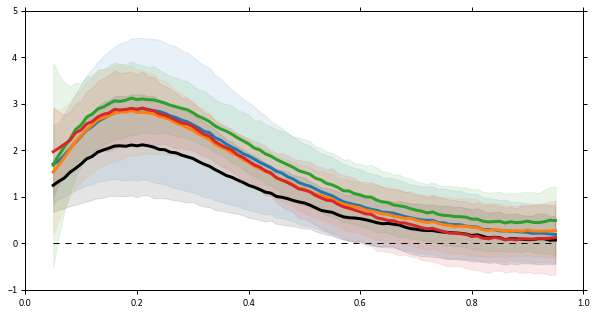

In [9]:
'''
description of data structures:

'''

diff_means = [mean for key,mean in sorted(diff_mean_dict.items())] 
diff_stds = [std for key,std in sorted(diff_std_dict.items())]
color_list = ['000000','#1f77b4','#ff7f0e','#2ca02c','#d62728']
x *= 100 # change the x to something easier to read (actual percentages)

f,ax = plt.subplots(1)
for i,mean in enumerate(diff_means):
    ax.plot(x,mean,linewidth=3,color=color_list[i])
for i,std in enumerate(diff_stds):
    ax.fill_between(x,(diff_means[i]-std),(diff_means[i]+std),color=color_list[i],alpha=0.1)
ax.hlines(0,x.min(),x.max(),linestyle='--')    

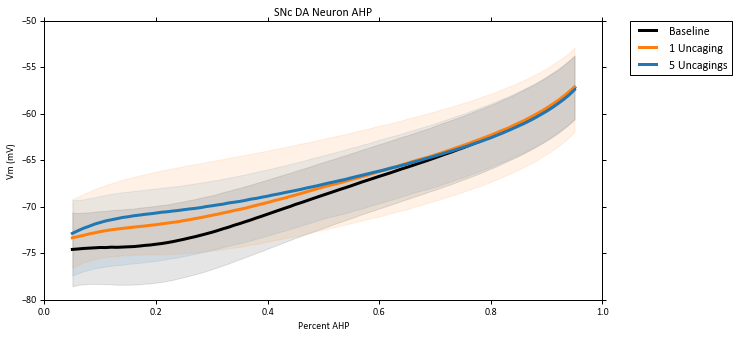

In [10]:
# need a plot of pre and post means

f,ax = plt.subplots(1)
ax.plot(x,pre_means['sweep001'],linewidth=3)
ax.fill_between(x,(pre_means['sweep001']-pre_stds['sweep001']),
                 (pre_means['sweep001']+pre_stds['sweep001']),
                 alpha=0.1,color=color_list[0])
ax.plot(x,post_means['sweep001'],linewidth=3)
ax.fill_between(x,(post_means['sweep001']-post_stds['sweep001']),
                 (post_means['sweep001']+post_stds['sweep001']),
                 alpha=0.1,color=color_list[1])
ax.plot(x,post_means['sweep005'],linewidth=3)
ax.fill_between(x,(post_means['sweep005']-post_stds['sweep005']),
                 (post_means['sweep005']+post_stds['sweep005']),
                 alpha=0.1,color=color_list[2])
ax.set_title('SNc DA Neuron AHP')
ax.set_xlabel('Percent AHP')
ax.set_ylabel('Vm (mV)')
ax.legend(('Baseline','1 Uncaging','5 Uncagings'),
          bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()

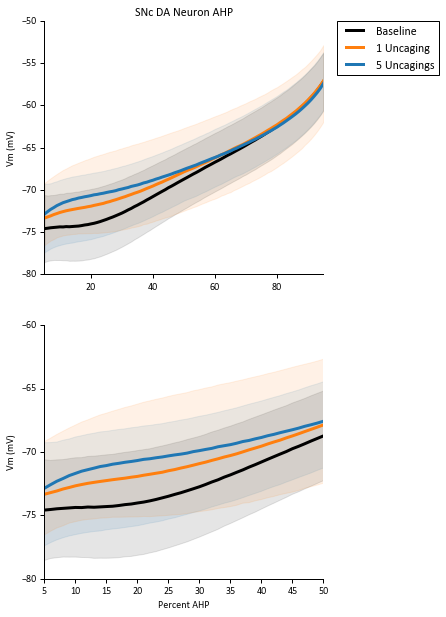

In [29]:
# need a plot of pre and post means

f,ax = plt.subplots(2,figsize=(5,10))

ax[0].plot(x,pre_means['sweep001'],linewidth=3)
ax[0].fill_between(x,(pre_means['sweep001']-pre_stds['sweep001']),
                 (pre_means['sweep001']+pre_stds['sweep001']),
                 alpha=0.1,color=color_list[0])
ax[0].plot(x,post_means['sweep001'],linewidth=3)
ax[0].fill_between(x,(post_means['sweep001']-post_stds['sweep001']),
                 (post_means['sweep001']+post_stds['sweep001']),
                 alpha=0.1,color=color_list[1])
ax[0].plot(x,post_means['sweep005'],linewidth=3)
ax[0].fill_between(x,(post_means['sweep005']-post_stds['sweep005']),
                 (post_means['sweep005']+post_stds['sweep005']),
                 alpha=0.1,color=color_list[2])
ax[0].set_title('SNc DA Neuron AHP')
ax[0].set_ylabel('Vm (mV)')
ax[0].set_xlim(5,95)
ax[0].legend(('Baseline','1 Uncaging','5 Uncagings'),
          bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

ax[1].plot(x,pre_means['sweep001'],linewidth=3)
ax[1].fill_between(x,(pre_means['sweep001']-pre_stds['sweep001']),
                 (pre_means['sweep001']+pre_stds['sweep001']),
                 alpha=0.1,color=color_list[0])
ax[1].plot(x,post_means['sweep001'],linewidth=3)
ax[1].fill_between(x,(post_means['sweep001']-post_stds['sweep001']),
                 (post_means['sweep001']+post_stds['sweep001']),
                 alpha=0.1,color=color_list[1])
ax[1].plot(x,post_means['sweep005'],linewidth=3)
ax[1].fill_between(x,(post_means['sweep005']-post_stds['sweep005']),
                 (post_means['sweep005']+post_stds['sweep005']),
                 alpha=0.1,color=color_list[2])
ax[1].set_xlabel('Percent AHP')
ax[1].set_ylabel('Vm (mV)')
ax[1].set_xlim(5,50)
ax[1].set_ylim(-80,-60)

nu.nuplot.simple_figure(f)

plt.show()

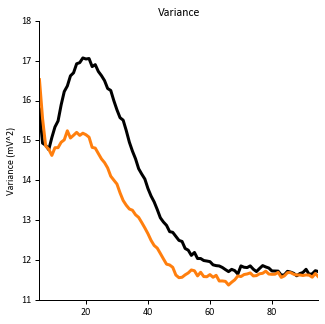

In [30]:
# need a plot of pre and post variance 

f,ax = plt.subplots(1,figsize=(5,5))

ax.plot(x,pre_stds['sweep001']**2,linewidth=3)
# ax.plot(x,pre_stds['sweep002']**2,linewidth=3)
# ax.plot(x,pre_stds['sweep003']**2,linewidth=3)
# ax.plot(x,pre_stds['sweep004']**2,linewidth=3)
# ax.plot(x,pre_stds['sweep005']**2,linewidth=3)

ax.plot(x,post_stds['sweep001']**2,linewidth=3)
# ax.plot(x,post_stds['sweep002']**2,linewidth=3)
# ax.plot(x,post_stds['sweep003']**2,linewidth=3)
# ax.plot(x,post_stds['sweep004']**2,linewidth=3)
# ax.plot(x,post_stds['sweep005']**2,linewidth=3)

ax.set_title('Variance')
ax.set_ylabel('Variance (mV^2)')
ax.set_xlim(5,95)
# ax.legend(('Baseline','1 Uncaging','5 Uncagings'),bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

nu.nuplot.simple_figure(f)

plt.show()

# Put the plots together

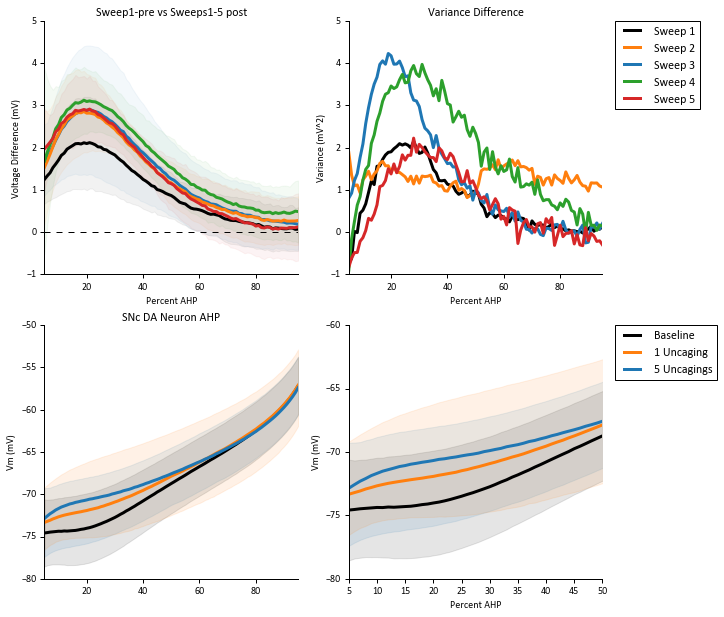

In [33]:
# code 

color_list = ['000000','#1f77b4','#ff7f0e','#2ca02c','#d62728']
sweep_list = ['Sweep {0}'.format(i) for i in range(1,6)]

f,ax = plt.subplots(2,2,figsize=(10,10))

# ax[0,0] top left - sweep1pre-sweep1post, sweep1pre-sweep2post, ...
for i,mean in enumerate(diff_means):
    ax[0,0].plot(x,mean,linewidth=3,color=color_list[i])
for i,std in enumerate(diff_stds):
    ax[0,0].fill_between(x,(diff_means[i]-std),(diff_means[i]+std),color=color_list[i],alpha=0.05)
ax[0,0].hlines(0,x.min(),x.max(),linestyle='--')
ax[0,0].set_title('Sweep1-pre vs Sweeps1-5 post')
ax[0,0].set_xlabel('Percent AHP')
ax[0,0].set_ylabel('Voltage Difference (mV)')
ax[0,0].set_xlim(5,95)


# # ax[0,1] top right
for i,sweep in enumerate(pre_stds):
    ax[0,1].plot(x,(pre_stds[sweep]**2-post_stds[sweep]**2),linewidth=3)
# ax[0,1].plot(x,pre_stds['sweep001']**2-post_stds['sweep001']**2,linewidth=3)
# ax[0,1].hlines(0,x.min(),x.max(),linestyle='--')
ax[0,1].set_title('Variance Difference')
ax[0,1].set_xlabel('Percent AHP')
ax[0,1].set_ylabel('Variance (mV^2)')
ax[0,1].set_xlim(5,95)
ax[0,1].legend(sweep_list,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)


# ax[1,0] bottom left
ax[1,0].plot(x,pre_means['sweep001'],linewidth=3)
ax[1,0].fill_between(x,(pre_means['sweep001']-pre_stds['sweep001']),
                 (pre_means['sweep001']+pre_stds['sweep001']),
                 alpha=0.1,color=color_list[0])
ax[1,0].plot(x,post_means['sweep001'],linewidth=3)
ax[1,0].fill_between(x,(post_means['sweep001']-post_stds['sweep001']),
                 (post_means['sweep001']+post_stds['sweep001']),
                 alpha=0.1,color=color_list[1])
ax[1,0].plot(x,post_means['sweep005'],linewidth=3)
ax[1,0].fill_between(x,(post_means['sweep005']-post_stds['sweep005']),
                 (post_means['sweep005']+post_stds['sweep005']),
                 alpha=0.1,color=color_list[2])
ax[1,0].set_title('SNc DA Neuron AHP')
ax[1,0].set_ylabel('Vm (mV)')
ax[1,0].set_xlim(5,95)


# ax[1,1] bottom right
ax[1,1].plot(x,pre_means['sweep001'],linewidth=3)
ax[1,1].fill_between(x,(pre_means['sweep001']-pre_stds['sweep001']),
                 (pre_means['sweep001']+pre_stds['sweep001']),
                 alpha=0.1,color=color_list[0])
ax[1,1].plot(x,post_means['sweep001'],linewidth=3)
ax[1,1].fill_between(x,(post_means['sweep001']-post_stds['sweep001']),
                 (post_means['sweep001']+post_stds['sweep001']),
                 alpha=0.1,color=color_list[1])
ax[1,1].plot(x,post_means['sweep005'],linewidth=3)
ax[1,1].fill_between(x,(post_means['sweep005']-post_stds['sweep005']),
                 (post_means['sweep005']+post_stds['sweep005']),
                 alpha=0.1,color=color_list[2])
ax[1,1].set_xlabel('Percent AHP')
ax[1,1].set_ylabel('Vm (mV)')
ax[1,1].set_xlim(5,50)
ax[1,1].set_ylim(-80,-60)
ax[1,1].legend(('Baseline','1 Uncaging','5 Uncagings'),bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0) 

nu.nuplot.simple_figure(f)

plt.show()
# f.savefig('/Users/chadestep/Documents/Northwestern/Surmeier/PROJECTS/Thesis Projects/3 - GABA/Manuscript/FiguresAHP analysis.pdf',
# bbox_inches='tight',pad_inches=0)

---
# Stats (sweep001)
## - Wilcoxon sign-rank test
### Controlling for Type I error: Family-Wise Error rate (FWER - incorrectly rejecting even a single null hypothesis) with the _Holmes correction_ (Tends to be more stringent than FDR correction, which I am all for.)

In [34]:
sweep = 'sweep001'
pvals = []
for percen in sorted(pre_df_dict[sweep]):
    _,pval = scipy.stats.wilcoxon(pre_df_dict['sweep001'][percen],post_df_dict[sweep][percen])
    pvals.append(pval)    

In [35]:
reject_null,corrected_p,alphacSidak,alphacBonf = statsmodels.sandbox.stats.multicomp.multipletests(
    pvals, alpha=0.05, method='holm')
print('reject_null: {0}...'.format(reject_null[:5]))
print('corrected_p: {0}...'.format(corrected_p[:5]))
print('alphacSidak: {0}'.format(alphacSidak))
print('alphacBonf: {0}'.format(alphacBonf))
print('')
print('20% reject_null: {0}'.format(reject_null[14]))
print('20% corrected_p: {0}'.format(corrected_p[14]))
print('')
print('range of sig differences: {0}% -> {1}%'.format(0,(100*percentiles[reject_null][-1])))

reject_null: [ True  True  True  True  True]...
corrected_p: [ 0.01318314  0.01318314  0.01318314  0.01318314  0.01318314]...
alphacSidak: 0.0005635037477809135
alphacBonf: 0.0005494505494505495

20% reject_null: True
20% corrected_p: 0.013183140687640465

range of sig differences: 0% -> 66.0%


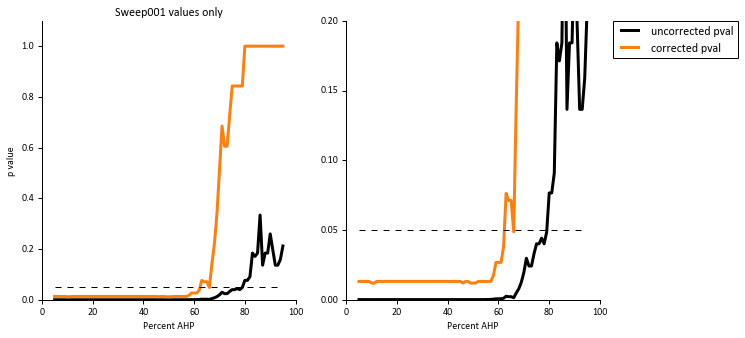

In [36]:
f,ax = plt.subplots(1,2)
ax[0].plot(x,pvals,linewidth=3)
ax[0].plot(x,corrected_p,linewidth=3)
ax[0].plot(x,[0.05]*len(x),linestyle='--',color='000000')
ax[0].set_ylim(0,1.1)
ax[0].set_xlabel('Percent AHP')
ax[0].set_ylabel('p value')
ax[0].set_title('Sweep001 values only')

ax[1].plot(x,pvals,linewidth=3)
ax[1].plot(x,corrected_p,linewidth=3)
ax[1].plot(x,[0.05]*len(x),linestyle='--',color='000000')
ax[1].set_ylim(0,0.2)
ax[1].set_xlabel('Percent AHP')
ax[1].legend(('uncorrected pval','corrected pval'),bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

nu.simple_figure(f)
f.savefig('/Users/chadestep/Documents/Northwestern/Surmeier/PROJECTS/Thesis Projects/3 - GABA/Manuscript/Figures/AHP pvals.pdf',
bbox_inches='tight',pad_inches=0)

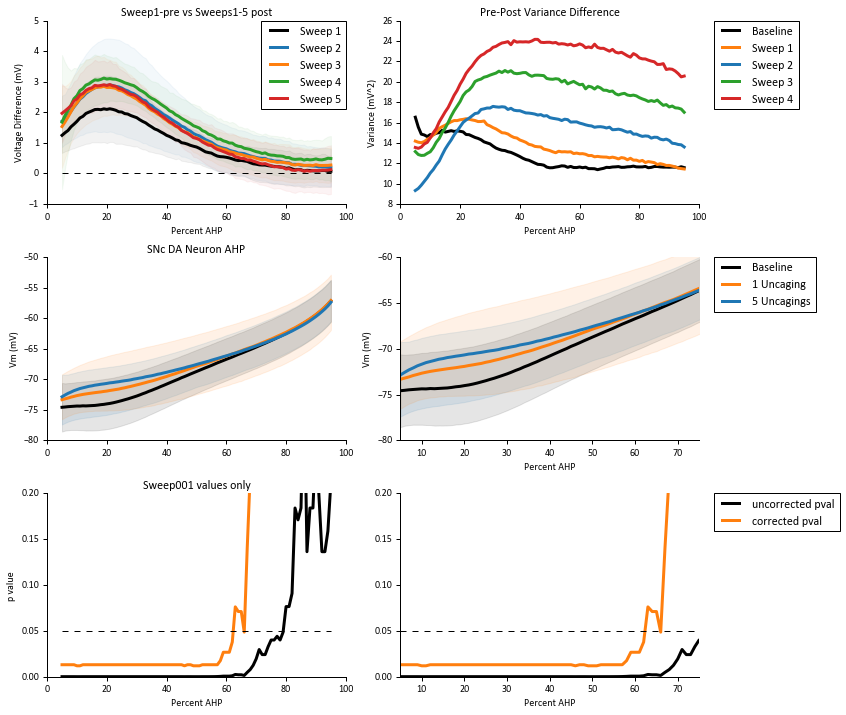

In [56]:
color_list = ['000000','#1f77b4','#ff7f0e','#2ca02c','#d62728']
sweep_list = ['Sweep {0}'.format(i) for i in range(1,6)]

f,ax = plt.subplots(3,2,figsize=(10,10))

# ax[0,0] top left - sweep1pre-sweep1post, sweep1pre-sweep2post, ...
for i,mean in enumerate(diff_means):
    ax[0,0].plot(x,mean,linewidth=3,color=color_list[i])
for i,std in enumerate(diff_stds):
    ax[0,0].fill_between(x,(diff_means[i]-std),(diff_means[i]+std),color=color_list[i],alpha=0.05)
ax[0,0].hlines(0,x.min(),x.max(),linestyle='--')
ax[0,0].set_title('Sweep1-pre vs Sweeps1-5 post')
ax[0,0].set_xlabel('Percent AHP')
ax[0,0].set_ylabel('Voltage Difference (mV)')
ax[0,0].legend(sweep_list, loc=1, borderaxespad=0)

# # ax[0,1] top right
# ax[0,1].plot(x,pre_stds['sweep001']**2,linewidth=3)
for i,sweep in enumerate(pre_stds):
#     ax[0,1].plot(x,(pre_stds[sweep]**2-post_stds[sweep]**2),linewidth=3)
#     ax[0,1].plot(x,(pre_stds['sweep001']**2-post_stds[sweep]**2),linewidth=3)
#     ax[0,1].plot(x,(post_stds[sweep]**2-pre_stds['sweep001']**2),linewidth=3)
    ax[0,1].plot(x,(post_stds[sweep]**2),linewidth=3)
ax[0,1].set_title('Pre-Post Variance Difference')
ax[0,1].set_xlabel('Percent AHP')
ax[0,1].set_ylabel('Variance (mV^2)')
# ax[0,1].set_xlim(5,95)
ax[0,1].legend(sweep_list,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)


# ax[1,0] mid left
ax[1,0].plot(x,pre_means['sweep001'],linewidth=3)
ax[1,0].fill_between(x,(pre_means['sweep001']-pre_stds['sweep001']),
                 (pre_means['sweep001']+pre_stds['sweep001']),
                 alpha=0.1,color=color_list[0])
ax[1,0].plot(x,post_means['sweep001'],linewidth=3)
ax[1,0].fill_between(x,(post_means['sweep001']-post_stds['sweep001']),
                 (post_means['sweep001']+post_stds['sweep001']),
                 alpha=0.1,color=color_list[1])
ax[1,0].plot(x,post_means['sweep005'],linewidth=3)
ax[1,0].fill_between(x,(post_means['sweep005']-post_stds['sweep005']),
                 (post_means['sweep005']+post_stds['sweep005']),
                 alpha=0.1,color=color_list[2])
ax[1,0].set_title('SNc DA Neuron AHP')
ax[1,0].set_ylabel('Vm (mV)')


# ax[1,1] mid right
ax[1,1].plot(x,pre_means['sweep001'],linewidth=3)
ax[1,1].fill_between(x,(pre_means['sweep001']-pre_stds['sweep001']),
                 (pre_means['sweep001']+pre_stds['sweep001']),
                 alpha=0.1,color=color_list[0])
ax[1,1].plot(x,post_means['sweep001'],linewidth=3)
ax[1,1].fill_between(x,(post_means['sweep001']-post_stds['sweep001']),
                 (post_means['sweep001']+post_stds['sweep001']),
                 alpha=0.1,color=color_list[1])
ax[1,1].plot(x,post_means['sweep005'],linewidth=3)
ax[1,1].fill_between(x,(post_means['sweep005']-post_stds['sweep005']),
                 (post_means['sweep005']+post_stds['sweep005']),
                 alpha=0.1,color=color_list[2])
ax[1,1].set_xlabel('Percent AHP')
ax[1,1].set_ylabel('Vm (mV)')
ax[1,1].set_xlim(5,75)
ax[1,1].set_ylim(-80,-60)
ax[1,1].legend(('Baseline','1 Uncaging','5 Uncagings'),bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0) 

# bottom left
ax[2,0].plot(x,pvals,linewidth=3)
ax[2,0].plot(x,corrected_p,linewidth=3)
ax[2,0].plot(x,[0.05]*len(x),linestyle='--',color='000000')
ax[2,0].set_ylim(0,0.2)
ax[2,0].set_xlabel('Percent AHP')
ax[2,0].set_ylabel('p value')
ax[2,0].set_title('Sweep001 values only')

# bottom right
ax[2,1].plot(x,pvals,linewidth=3)
ax[2,1].plot(x,corrected_p,linewidth=3)
ax[2,1].plot(x,[0.05]*len(x),linestyle='--',color='000000')
ax[2,1].set_ylim(0,0.2)
ax[2,1].set_xlim(5,75)
ax[2,1].set_xlabel('Percent AHP')
ax[2,1].legend(('uncorrected pval','corrected pval'),bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

nu.nuplot.simple_figure(f)
plt.tight_layout()

plt.show()

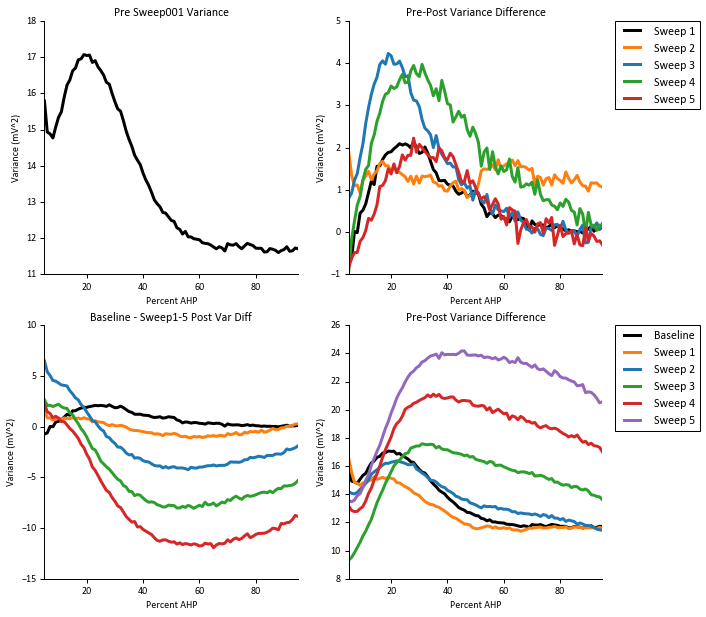

In [59]:
# Need to move some of them around, but overall still not bad

f,ax = plt.subplots(2,2,figsize=(10,10))

ax[0,0].plot(x,pre_stds['sweep001']**2,linewidth=3)
ax[0,0].set_title('Pre Sweep001 Variance')
ax[0,0].set_xlabel('Percent AHP')
ax[0,0].set_ylabel('Variance (mV^2)')
ax[0,0].set_xlim(5,95)

for i,sweep in enumerate(pre_stds):
    ax[0,1].plot(x,(pre_stds[sweep]**2-post_stds[sweep]**2),linewidth=3)
ax[0,1].set_title('Sweep Pre-Post Variance Difference')
ax[0,1].set_xlabel('Percent AHP')
ax[0,1].set_ylabel('Variance (mV^2)')
ax[0,1].set_xlim(5,95)
ax[0,1].legend(sweep_list,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

for i,sweep in enumerate(pre_stds):
    ax[1,0].plot(x,(pre_stds['sweep001']**2-post_stds[sweep]**2),linewidth=3)
#     ax[1,0].plot(x,(post_stds[sweep]**2-pre_stds['sweep001']**2),linewidth=3)    
ax[1,0].set_title('Baseline - Sweep1-5 Post Var Diff')
ax[1,0].set_xlabel('Percent AHP')
ax[1,0].set_ylabel('Variance (mV^2)')
ax[1,0].set_xlim(5,95)
# ax[0,1].legend(sweep_list,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

ax[1,1].plot(x,pre_stds['sweep001']**2,linewidth=3)
for i,sweep in enumerate(pre_stds):
#     ax[1,1].plot(x,(post_stds[sweep]**2-pre_stds['sweep001']**2),linewidth=3)
    ax[1,1].plot(x,(post_stds[sweep]**2),linewidth=3)
ax[1,1].set_title('Pre-Post Variance Difference')
ax[1,1].set_xlabel('Percent AHP')
ax[1,1].set_ylabel('Variance (mV^2)')
ax[1,1].set_xlim(5,95)
ax[1,1].legend(['Baseline']+sweep_list,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

nu.nuplot.simple_figure(f)